In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.config import DADOS_CATEGORIZADOS
from src.graficos import (
    plot_coeficientes,
    plot_residuos
)

from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    QuantileTransformer,
    StandardScaler
)

sns.set_theme(palette='bright')

RANDOM_STATE = 42

In [2]:
df = pd.read_parquet(DADOS_CATEGORIZADOS)

df.head()

,idade,sexo,imc,pressao_media,colesterol_total,ldl,hdl,triglicerides,glicose,target,colesterol_hdl_cat
0,59,2,32.099998,101.0,157,93.199997,38.0,4.8598,87,151,4-5
1,48,1,21.600000,87.0,183,103.199997,70.0,3.8918,69,75,2-3
2,72,2,30.500000,93.0,156,93.599998,41.0,4.6728,85,141,4-5
3,24,1,25.299999,84.0,198,131.399994,40.0,4.8903,89,206,4-5
4,50,1,23.000000,101.0,192,125.400002,52.0,4.2905,80,135,4-5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   idade               442 non-null    int8    
 1   sexo                442 non-null    int8    
 2   imc                 442 non-null    float32 
 3   pressao_media       442 non-null    float32 
 4   colesterol_total    442 non-null    int16   
 5   ldl                 442 non-null    float32 
 6   hdl                 442 non-null    float32 
 7   triglicerides       442 non-null    float32 
 8   glicose             442 non-null    int8    
 9   target              442 non-null    int16   
 10  colesterol_hdl_cat  442 non-null    category
dtypes: category(1), float32(5), int16(2), int8(3)
memory usage: 12.3 KB


In [4]:
colunas_power_transform = ['imc', 'ldl', 'hdl', 'colesterol_total']

coluna_target = ['target']

coluna_ordinal_encoder = ['colesterol_hdl_cat']

coluna_one_hot_encoder = ['sexo']

colunas_standard_scaler = [
    coluna for coluna in df.columns
        if coluna not in colunas_power_transform + coluna_target + coluna_ordinal_encoder + coluna_one_hot_encoder
]

colunas_standard_scaler

['idade', 'pressao_media', 'triglicerides', 'glicose']

In [5]:
categorias_ordinal_encoder = [['2-3', '4-5', '6+']]

In [6]:
X = df.drop(columns='target')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [7]:
preprocessamento = ColumnTransformer(
    [
        ('power_transform', PowerTransformer(method='box-cox'), colunas_power_transform),
        ('standard_scaler', StandardScaler(), colunas_standard_scaler),
        ('ordinal_encoder', OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ('one_hot_encoder', OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder)
    ]
)

In [8]:
pipeline = Pipeline([
    ('preprocessor', preprocessamento),
    ('reg', LinearRegression())
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('power_transform',
                                                  PowerTransformer(method='box-cox'),
                                                  ['imc', 'ldl', 'hdl',
                                                   'colesterol_total']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['idade', 'pressao_media',
                                                   'triglicerides',
                                                   'glicose']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['2-3',
                                                                              '4-5',
                                                                              '6+']]),
                                                  ['colesterol_hdl_cat']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sexo'])])),
                ('reg', LinearRegression())])

In [9]:
regressor = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=QuantileTransformer(n_quantiles=20, output_distribution='normal')
)

regressor

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('power_transform',
                                                                                       PowerTransformer(method='box-cox'),
                                                                                       ['imc',
                                                                                        'ldl',
                                                                                        'hdl',
                                                                                        'colesterol_total']),
                                                                                      ('standard_scaler',
                                                                                       StandardScaler(),
                                                                                       ['idade',
                                                                                        'pressao_media',
                                                                                        'triglicerides',
                                                                                        'glicose']),
                                                                                      ('ordinal_encoder',
                                                                                       OrdinalEncoder(categories=[['2-3',
                                                                                                                   '4-5',
                                                                                                                   '6+']]),
                                                                                       ['colesterol_hdl_cat']),
                                                                                      ('one_hot_encoder',
                                                                                       OneHotEncoder(drop='if_binary'),
                                                                                       ['sexo'])])),
                                                     ('reg',
                                                      LinearRegression())]),
                           transformer=QuantileTransformer(n_quantiles=20,
                                                           output_distribution='normal'))

In [10]:
regressor.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('power_transform',
                                                                                       PowerTransformer(method='box-cox'),
                                                                                       ['imc',
                                                                                        'ldl',
                                                                                        'hdl',
                                                                                        'colesterol_total']),
                                                                                      ('standard_scaler',
                                                                                       StandardScaler(),
                                                                                       ['idade',
                                                                                        'pressao_media',
                                                                                        'triglicerides',
                                                                                        'glicose']),
                                                                                      ('ordinal_encoder',
                                                                                       OrdinalEncoder(categories=[['2-3',
                                                                                                                   '4-5',
                                                                                                                   '6+']]),
                                                                                       ['colesterol_hdl_cat']),
                                                                                      ('one_hot_encoder',
                                                                                       OneHotEncoder(drop='if_binary'),
                                                                                       ['sexo'])])),
                                                     ('reg',
                                                      LinearRegression())]),
                           transformer=QuantileTransformer(n_quantiles=20,
                                                           output_distribution='normal'))

In [11]:
regressor.regressor_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('power_transform',
                                                  PowerTransformer(method='box-cox'),
                                                  ['imc', 'ldl', 'hdl',
                                                   'colesterol_total']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['idade', 'pressao_media',
                                                   'triglicerides',
                                                   'glicose']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['2-3',
                                                                              '4-5',
                                                                              '6+']]),
                                                  ['colesterol_hdl_cat']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sexo'])])),
                ('reg', LinearRegression())])

In [12]:
regressor.transformer_

QuantileTransformer(n_quantiles=20, output_distribution='normal')

In [13]:
regressor.regressor_.named_steps

{'preprocessor': ColumnTransformer(transformers=[('power_transform',
                                  PowerTransformer(method='box-cox'),
                                  ['imc', 'ldl', 'hdl', 'colesterol_total']),
                                 ('standard_scaler', StandardScaler(),
                                  ['idade', 'pressao_media', 'triglicerides',
                                   'glicose']),
                                 ('ordinal_encoder',
                                  OrdinalEncoder(categories=[['2-3', '4-5',
                                                              '6+']]),
                                  ['colesterol_hdl_cat']),
                                 ('one_hot_encoder',
                                  OneHotEncoder(drop='if_binary'), ['sexo'])]),
 'reg': LinearRegression()}

In [15]:
regressor.regressor_['reg'].coef_

array([ 0.31483251,  0.3189292 ,  0.04103131, -0.54429825,  0.0206579 ,
        0.16631542,  0.45027707,  0.03326154,  0.18542335, -0.31685863])

In [16]:
regressor.regressor_['reg'].intercept_

np.float64(0.0166683256353621)

In [17]:
regressor.regressor_['preprocessor'].feature_names_in_

array(['idade', 'sexo', 'imc', 'pressao_media', 'colesterol_total', 'ldl',
       'hdl', 'triglicerides', 'glicose', 'colesterol_hdl_cat'],
      dtype=object)

In [18]:
regressor.regressor_['preprocessor'].get_feature_names_out()

array(['power_transform__imc', 'power_transform__ldl',
       'power_transform__hdl', 'power_transform__colesterol_total',
       'standard_scaler__idade', 'standard_scaler__pressao_media',
       'standard_scaler__triglicerides', 'standard_scaler__glicose',
       'ordinal_encoder__colesterol_hdl_cat', 'one_hot_encoder__sexo_2'],
      dtype=object)

In [20]:
coefs = dataframe_coeficientes(
    regressor.regressor_['reg'].coef_,
    regressor.regressor_['preprocessor'].get_feature_names_out()
)

coefs

,coeficiente
power_transform__colesterol_total,-0.544298
one_hot_encoder__sexo_2,-0.316859
standard_scaler__idade,0.020658
standard_scaler__glicose,0.033262
power_transform__hdl,0.041031
standard_scaler__pressao_media,0.166315
ordinal_encoder__colesterol_hdl_cat,0.185423
power_transform__imc,0.314833
power_transform__ldl,0.318929
standard_scaler__triglicerides,0.450277


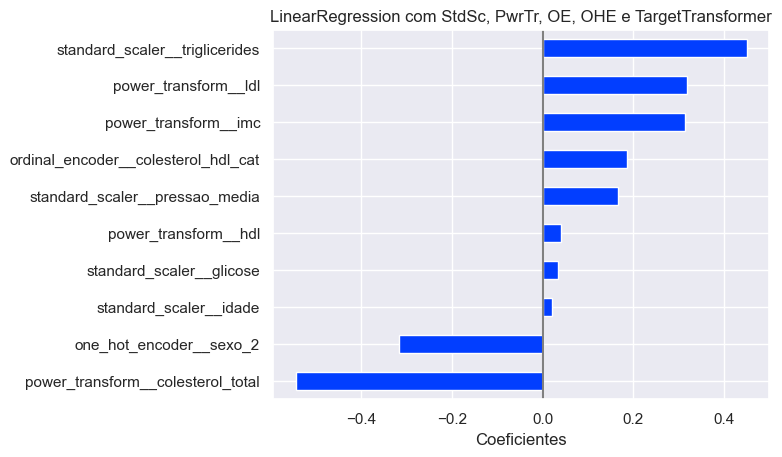

In [21]:
plot_coeficientes(coefs, 'LinearRegression com StdSc, PwrTr, OE, OHE e TargetTransformer')

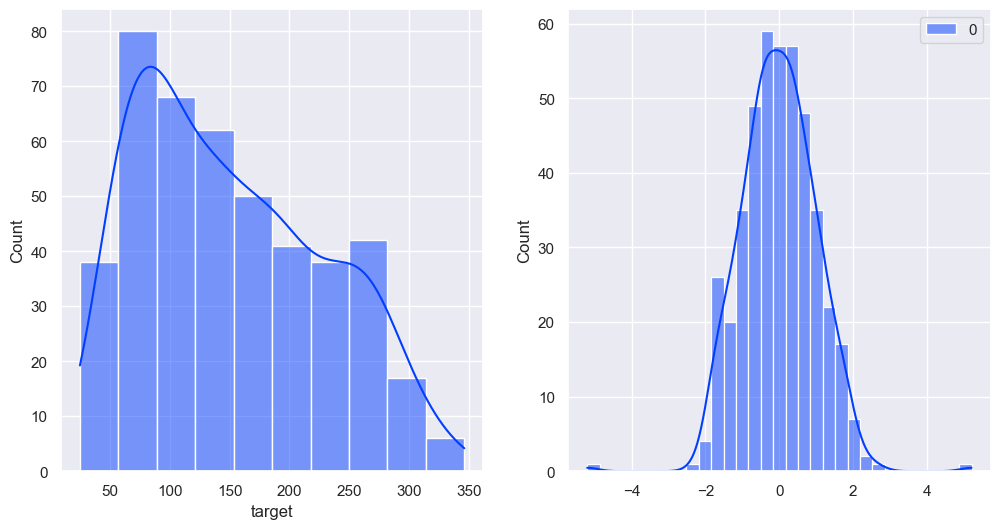

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(y, ax=axs[0], kde=True)

y_transformado = regressor.transformer_.transform(y.values.reshape(-1, 1))

sns.histplot(y_transformado, ax=axs[1], kde=True)

plt.show()